<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Project-description" data-toc-modified-id="Project-description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Project description</a></span></li><li><span><a href="#Make-feature-file" data-toc-modified-id="Make-feature-file-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Make feature file</a></span></li><li><span><a href="#Train-test" data-toc-modified-id="Train-test-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train-test</a></span></li><li><span><a href="#Apply-on-data" data-toc-modified-id="Apply-on-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Apply on data</a></span><ul class="toc-item"><li><span><a href="#Higher-resolution" data-toc-modified-id="Higher-resolution-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Higher resolution</a></span></li><li><span><a href="#Exclude-number-of-events-before/during-debris-flows" data-toc-modified-id="Exclude-number-of-events-before/during-debris-flows-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Exclude number of events before/during debris flows</a></span></li></ul></li><li><span><a href="#Different-events" data-toc-modified-id="Different-events-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Different events</a></span></li></ul></div>

In [6]:
#%matplotlib notebook
import numpy as np
import pandas as pd
import obspy
import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import random
from itertools import combinations
from datetime import datetime, timedelta
import time
from itertools import cycle
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score #new
from sklearn.linear_model import LinearRegression #new
from sklearn.model_selection import KFold #new
from sklearn.model_selection import cross_val_score #new
from sklearn.model_selection import train_test_split
from obspy.clients.filesystem.sds import Client
from scipy import signal
import seaborn as sns
import joblib
import itertools
import glob
from ComputeAttributes_CH_V1 import *

ImportError: dlopen(/Users/koepflma/opt/miniconda3/envs/ILLenv/lib/python3.10/site-packages/scipy/sparse/linalg/_isolve/_iterative.cpython-310-darwin.so, 0x0002): Library not loaded: @rpath/liblapack.3.dylib
  Referenced from: <A2D034BC-D9BB-3875-ABAC-2EDB48E79E26> /Users/koepflma/opt/miniconda3/envs/ILLenv/lib/python3.10/site-packages/scipy/sparse/linalg/_isolve/_iterative.cpython-310-darwin.so
  Reason: tried: '/Users/koepflma/opt/miniconda3/envs/ILLenv/lib/python3.10/site-packages/scipy/sparse/linalg/_isolve/liblapack.3.dylib' (no such file), '/Users/koepflma/opt/miniconda3/envs/ILLenv/lib/python3.10/site-packages/scipy/sparse/linalg/_isolve/../../../../../../liblapack.3.dylib' (no such file), '/Users/koepflma/opt/miniconda3/envs/ILLenv/lib/python3.10/site-packages/scipy/sparse/linalg/_isolve/liblapack.3.dylib' (no such file), '/Users/koepflma/opt/miniconda3/envs/ILLenv/lib/python3.10/site-packages/scipy/sparse/linalg/_isolve/../../../../../../liblapack.3.dylib' (no such file), '/Users/koepflma/opt/miniconda3/envs/ILLenv/bin/../lib/liblapack.3.dylib' (no such file), '/Users/koepflma/opt/miniconda3/envs/ILLenv/bin/../lib/liblapack.3.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS@rpath/liblapack.3.dylib' (no such file), '/Users/koepflma/opt/miniconda3/envs/ILLenv/lib/python3.10/site-packages/scipy/sparse/linalg/_isolve/liblapack.3.dylib' (no such file), '/Users/koepflma/opt/miniconda3/envs/ILLenv/lib/python3.10/site-packages/scipy/sparse/linalg/_isolve/../../../../../../liblapack.3.dylib' (no such file), '/Users/koepflma/opt/miniconda3/envs/ILLenv/lib/python3.10/site-packages/scipy/sparse/linalg/_isolve/liblapack.3.dylib' (no such file), '/Users/koepflma/opt/miniconda3/envs/ILLenv/lib/python3.10/site-packages/scipy/sparse/linalg/_isolve/../../../../../../liblapack.3.dylib' (no such file), '/Users/koepflma/opt/miniconda3/envs/ILLenv/bin/../lib/liblapack.3.dylib' (no such file), '/Users/koepflma/opt/miniconda3/envs/ILLenv/bin/../lib/liblapack.3.dylib' (no such file), '/usr/local/lib/liblapack.3.dylib' (no such file), '/usr/lib/liblapack.3.dylib' (no such file, not in dyld cache)

In [2]:
# set plotting default parameters
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.figsize'] = (6.4, 4.8) # if wider plot, only change first value.
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Verdana']
#plt.rcParams['ytick.major.pad']= 2

In [3]:
path_to_raw_data = '/media/manuela/Elements/illgraben/miniseed/'

# Project description

In this notebook we use a manually assembled event catalog containing slope failure events, earthquakes and noise signals recorded on Stations ILL16, ILL17 and ILL18.
We choose 40 s windows that start several seconds before the event-start in the catalog with a specific overlap (for further explanation see Wenner et al., 2021).
The generated/converted catalog is then used to compute features of the signals in the windows after Provost et al., 2017.
We then train a random forest classifier with manual picked events from 2017. The random forest classifier __distinguishes between two classes: slope failures and noise (including earthquakes)__.
Lastly, we apply the classifier on continuous data (2019) to look at seasonal variations in slope failure occurance and the impact of climatic forcing.

The notebook is structured in three main tasks:
1. Compute features from a snuffler file (pyrocko event picker format) -> 2017
2. Train and test a classifier
3. Apply on continuous data -> 2019

Explanations of the specific steps follow below

I, Manuela, did not create my one feature files. I used the ones Michaela gave me.

# Make feature file -> skip

Here, we read in a slightly modified snuffler file containing events picked on all Illgraben stations.


In [49]:
# Define file name ending
file_ending = '23_g'
# Mate catalog
df = pd.read_csv('../snuffler_files/event_catalog_man_cont_hSNR_v5.txt', delimiter=',')
df[10:15]

,startdate,starttime,enddate,endtime,duration,bla,class,network
10,2017-06-02,07:00:37.9249,2017-06-02,07:01:06.9365,29.011600017547607,NaN,4.0,XP.ILL02..EHZ
11,2017-06-02,07:00:38.2744,2017-06-02,07:01:06.8666,28.59220004081726,NaN,4.0,XP.ILL03..EHZ
12,2017-06-02,07:00:40.3017,2017-06-02,07:01:07.4259,27.124199867248535,NaN,4.0,XP.ILL01..EHZ
13,2017-06-02,10:02:57.8257,NaN,0,XP.ILL07..EHZ,NaN,NaN,NaN
14,2017-06-02,10:05:53.4261,2017-06-02,10:07:03.4020,69.97589993476868,NaN,1.0,None


In [113]:
# Define window length
wdow = 40

# Get times of continuous noise (class0)
# Snuffler output different than for events with starttime and endtime marked
# To sample continuous noise I only marked one timestamp at which nothing was happening
ct = df[df['endtime'] == '0'].reset_index(drop=True)
ct.head()

,startdate,starttime,enddate,endtime,duration,bla,class,network
0,2017-06-02,10:02:57.8257,NaN,0,XP.ILL07..EHZ,NaN,NaN,NaN
1,2017-06-02,10:08:39.0653,NaN,0,XP.ILL07..EHZ,NaN,NaN,NaN
2,2017-06-02,10:13:14.0537,NaN,0,XP.ILL07..EHZ,NaN,NaN,NaN
3,2017-06-02,10:22:11.1152,NaN,0,XP.ILL07..EHZ,NaN,NaN,NaN
4,2017-06-02,10:32:15.0563,NaN,0,XP.ILL07..EHZ,NaN,NaN,NaN


In [115]:
# Here I filter to only get events from station ILL08 and None (marked at all stations)
# I do this to avoid sampling noise from station ILL08, which we consider to be one of the most valuable stations for our problem
station_list = ['ILL08']
df7 = df[(df['network'] == f'XP.ILL08..EHZ') | (df['network'] == 'None')].reset_index(drop=True)
df7.head()

,startdate,starttime,enddate,endtime,duration,bla,class,network
0,2017-06-01,04:07:14.3219,2017-06-01,04:07:42.6177,28.29580020904541,NaN,3.0,XP.ILL08..EHZ
1,2017-06-02,05:43:37.0157,2017-06-02,05:43:52.3119,15.296199798583984,NaN,4.0,XP.ILL08..EHZ
2,2017-06-02,07:00:34.1965,2017-06-02,07:01:03.6467,29.450199842453003,NaN,4.0,XP.ILL08..EHZ
3,2017-06-02,10:05:53.4261,2017-06-02,10:07:03.4020,69.97589993476868,NaN,1.0,None
4,2017-06-02,12:58:23.5461,2017-06-02,12:58:53.4626,29.916500091552734,NaN,4.0,XP.ILL08..EHZ


In [52]:
# Assemble catalog
classes = []
event_idxs = []
slice_idxs = []
times = []
stations = []
for idx, row in df7.iterrows(): # df7 includes only ILL08 and None stations
    sdate = row['startdate']
    stime = row['starttime']
    stt = obspy.UTCDateTime(f"{sdate}T{stime}")
    edate = row['enddate']
    etime = row['endtime']
    edt = obspy.UTCDateTime(f"{edate}T{etime}")
    cla = row['class']
    station = row['network'][3:8] #ILLxx

    # Start random up to 2/3 of window length before marker starts
    tt = stt - np.random.randint(int((2/3)*wdow)) # random numbers up to 2/3*40 =26.66s 
    j = 0
    while tt < edt-(int((1/3)*wdow)): # End random up to 1/3 of window length (13.33s) before marker ends
        classes.append(cla)
        event_idxs.append(idx)
        slice_idxs.append(j)
        times.append(tt)

        if station == 'e': # in None
            stations.append(random.choice(station_list))
        else:
            stations.append(station)
        tt += int((1/3)*wdow) # overlap of about 2/3 (original code) & 1/3 (PhD Thesis text)
        j+=1

# Also add continuous noise to new catalog
for idxn, row in ct.iterrows():
    idx += 1 # attention: idx is NOT idxn
    sdate = row['startdate']
    stime = row['starttime']
    stt = obspy.UTCDateTime(f"{sdate}T{stime}")
    cla = 0

    classes.append(cla)
    event_idxs.append(idx)
    slice_idxs.append(0)
    times.append(stt + 0.5*wdow)
    stations.append('ILL08')#(random.choice(station_list))

# Get in dataframe format
dic_re = {'event_idx': event_idxs, 'slice_idx': slice_idxs, 'class': classes, 'mean_time': times, 'station': stations}
cat_re = pd.DataFrame(dic_re)
#cat_re[cat_re['class'] == 1]
print(cat_re.head())

# Save catalog
cat_re.to_csv(f"../catalog/catalog_{wdow}_hSNR_v5_{file_ending}.csv", index=False)
# output each time a bit different due to random element

   event_idx  slice_idx  class                    mean_time station
0          0          0    3.0  2017-06-01T04:07:08.321900Z   ILL08
1          0          1    3.0  2017-06-01T04:07:21.321900Z   ILL08
2          1          0    4.0  2017-06-02T05:43:31.015700Z   ILL08
3          2          0    4.0  2017-06-02T07:00:20.196500Z   ILL08
4          2          1    4.0  2017-06-02T07:00:33.196500Z   ILL08


#### => it is possible to start here and load the modified catalog file

In [53]:
# Read catalog
cat = pd.read_csv(f'../catalog/catalog_40_hSNR_v5_{file_ending}.csv')
#cat = pd.read_csv(f'../catalog/catalog_40_hSNR_v5.csv')
cat.head()

,event_idx,slice_idx,class,mean_time,station
0,0,0,3.0,2017-06-01T04:07:08.321900Z,ILL08
1,0,1,3.0,2017-06-01T04:07:21.321900Z,ILL08
2,1,0,4.0,2017-06-02T05:43:31.015700Z,ILL08
3,2,0,4.0,2017-06-02T07:00:20.196500Z,ILL08
4,2,1,4.0,2017-06-02T07:00:33.196500Z,ILL08


In [54]:
def get_mseed(time, client=Client(path_to_raw_data), 
              stations=['ILL06','ILL07','ILL08'],
              channels=['EHZ'], locations=[''], prepick=0, window_length=24*60*60.):

    st = obspy.Stream()
    for station in stations:
        for location in locations:
            for channel in channels:
                try:           
                    new_st = client.get_waveforms('XP', station, location, channel,
                                                obspy.UTCDateTime(time)-prepick, 
                                                obspy.UTCDateTime(time)-prepick+window_length)
                    st += new_st
                except:
                    continue
    return(st)

In [55]:
def create_feature_file(df, purpose, wdow, filt):
    """
    Creat attribute files from catalog

    :param df: pandas dataframe containing event_idx, slice_idx, class, mean_time and station
    :param purpose: purpose of attribute file (test or train)
    :type purpose: string
    """

    all_char = {}
    
    # Loop over rows in dataframe
    for idx, row in df.iterrows():
        #print(idx)
        tstring = row['mean_time']
        t = obspy.UTCDateTime(f"{tstring}")
        #station = row['station']
        feats = np.array([])
        
        # This folder should only contain stations you are interested in (in my case ILL16, ILL17, ILL18)
        st = get_mseed(obspy.UTCDateTime('{}-{}'.format(t.year,t.julday)))
        st.detrend('demean')
        st1 = st.copy()
        if filt == 'yes':
            st1.filter('bandpass', freqmin=1, freqmax=10)
            fi = 'yfilt'
        else:
            fi = 'nfilt'
        st1.trim(t - 0.5*wdow, t + 0.5*wdow) # cut stream to 40s (wdow) segments (20s before t and 20s after t)
        print(st1)                           # t = mean_time of event (from df7)
        for tr in st1:
            att = calculate_all_attributes(tr.data,tr.stats.sampling_rate,0) # Compute all atrributes
            feats = np.append(feats,att)
            print(len(feats))
        feats = np.reshape(feats,(1,len(feats)))
        
        
        ev_type = np.array([int(row['event_idx']),int(row['slice_idx']),int(row['class'])])
        type_att = np.append(ev_type, feats)
        type_att = np.reshape(type_att,(1,len(type_att)))
        type_att = pd.DataFrame(type_att)
        # Save to file
        with open(f'../feature_files/all_40s_hSNR_yfilt_v5_{file_ending}.csv', "a+") as f:
            type_att.to_csv(f, header=False,index=False)

In [56]:
# Create feature file --> time consuming
create_feature_file(cat, 'train', 40, 'yfilt')

3 Trace(s) in Stream:
XP.ILL06..EHZ | 2017-06-01T04:06:48.320000Z - 2017-06-01T04:07:28.320000Z | 100.0 Hz, 4001 samples
XP.ILL07..EHZ | 2017-06-01T04:06:48.320000Z - 2017-06-01T04:07:28.320000Z | 100.0 Hz, 4001 samples
XP.ILL08..EHZ | 2017-06-01T04:06:48.320000Z - 2017-06-01T04:07:28.320000Z | 100.0 Hz, 4001 samples
58
116
174
3 Trace(s) in Stream:
XP.ILL06..EHZ | 2017-06-01T04:07:01.320000Z - 2017-06-01T04:07:41.320000Z | 100.0 Hz, 4001 samples
XP.ILL07..EHZ | 2017-06-01T04:07:01.320000Z - 2017-06-01T04:07:41.320000Z | 100.0 Hz, 4001 samples
XP.ILL08..EHZ | 2017-06-01T04:07:01.320000Z - 2017-06-01T04:07:41.320000Z | 100.0 Hz, 4001 samples
58
116
174
3 Trace(s) in Stream:
XP.ILL06..EHZ | 2017-06-02T05:43:11.020000Z - 2017-06-02T05:43:51.020000Z | 100.0 Hz, 4001 samples
XP.ILL07..EHZ | 2017-06-02T05:43:11.020000Z - 2017-06-02T05:43:51.020000Z | 100.0 Hz, 4001 samples
XP.ILL08..EHZ | 2017-06-02T05:43:11.020000Z - 2017-06-02T05:43:51.020000Z | 100.0 Hz, 4001 samples
58
116
174
3 Trace(s)

In [42]:
# Read feature file
df = pd.read_csv(f'../feature_files/all_40s_hSNR_yfilt_{file_ending}.csv')
print(file_ending)
print(np.shape(df))

(529, 177)


# Train-test

#### => it is possible to start here and load the feature file file

In [4]:
# List of attributes we want to use for classification
attribute_names = ['duration', 'RappMaxMean','RappMaxMedian', 'AsDec', 'KurtoSig', \
                    'KurtoEnv', 'SkewnessSig', 'SkewnessEnv', 'CorPeakNumber', 'INT1', \
                    'INT2', 'INT_RATIO', 'ES[0]', 'ES[1]', 'ES[2]', 'ES[3]', 'ES[4]', 'KurtoF[0]', \
                    'KurtoF[1]', 'KurtoF[2]', 'KurtoF[3]', 'KurtoF[4]', 'DistDecAmpEnv', \
                    'env_max/duration(Data,sps)', 'MeanFFT', 'MaxFFT', 'FmaxFFT', \
                    'FCentroid', 'Fquart1', 'Fquart3', 'MedianFFT', 'VarFFT', 'NpeakFFT', \
                    'MeanPeaksFFT', 'E1FFT', 'E2FFT', 'E3FFT', 'E4FFT', 'gamma1', 'gamma2', \
                    'gammas', 'SpecKurtoMaxEnv', 'SpecKurtoMedianEnv', 'RATIOENVSPECMAXMEAN', \
                    'RATIOENVSPECMAXMEDIAN', 'DISTMAXMEAN', 'DISTMAXMEDIAN', 'NBRPEAKMAX', \
                    'NBRPEAKMEAN', 'NBRPEAKMEDIAN', 'RATIONBRPEAKMAXMEAN', \
                    'RATIONBRPEAKMAXMED', 'NBRPEAKFREQCENTER', 'NBRPEAKFREQMAX', \
                    'RATIONBRFREQPEAKS', 'DISTQ2Q1', 'DISTQ3Q2', 'DISTQ3Q1']

## v5 File -> skip

I, Manuela, did not use the v5 files. I used the v4 files from Michaela.

In [4]:
def train_test_grouped(df1, features, size):
    """
    Split into training and test data set such that events recorded on multiple stations will either be in train or in test data set
    Additional to sklearn function add feature values to X-files instead of only the event-index
    
    :param df1: whole data set
    :param gr: grouped per event index
    :param features: list of feautre names
    """
    # Get event idx and targets
    gr = df1.groupby('event_idx').first() # df inclueds only first time window per event
    idxs = np.asarray(gr.index) # index 0-290 (len = 291)
    y = np.asarray(gr['event_class']) # class 0 or 1 (len = 291)
    # Split training and validation data
    X_train, X_test, y_train, y_test = train_test_split(idxs, y, test_size=size,random_state=42)
    df_tr = df1.loc[df1['event_idx'].isin(X_train)] # df with feature values TRAIN
    df_va = df1.loc[df1['event_idx'].isin(X_test)] # df with feature values TEST
    X_train = np.asarray(df_tr[features]) # feature values to TRAIN
    y_train = np.asarray(df_tr['event_class']) # classes to TRAIN (only 0 and 1)
    X_test = np.asarray(df_va[features]) # feature values to TEST
    y_test = np.asarray(df_va['event_class']) # classes to TEST (only 0 and 1)
    return X_train, X_test, y_train, y_test

In [6]:
# Assemble whole header of feautre file
header = []
h = ['event_idx', 'slice_idx', 'event_class']
header = h + attribute_names + attribute_names + attribute_names # 3 times because 3 stations
#print(header)
print(len(header))

177


In [7]:
# Load feature file and set new header
plot_ending = 'v5_23_g'
df_ff = pd.read_csv('../feature_files/all_40s_hSNR_yfilt_v5_23_g.csv', header = None)
df_ff.columns = header
print(np.shape(df_ff)) # the three stations are behind each other (in x direction)

# Now we have to list the different stations below each other (in y direction)
df_final = pd.DataFrame()
for n in [3, 61, 119]:
    df_new = df_ff.iloc[:,:3].join(df_ff.iloc[:,n:n+58]) # first three cols copy and than add features
    df_final = df_final.append(df_new)
print(np.shape(df_final))

(534, 177)
(1602, 61)


In [8]:
# RFC can only handle two classes -> merge classes
def combine_classes_catalog_2(cat):
    cat.loc[cat['event_class'] != 3 , 'event_class'] = 0 # Earthqauke Illgraben to Noise
    cat.loc[cat['event_class'] == 3 , 'event_class'] = 1 # Earthqauke Illgraben from 3 to 1
    return cat

catalog = combine_classes_catalog_2(df_final)
catalog

,event_idx,slice_idx,event_class,duration,RappMaxMean,RappMaxMedian,AsDec,KurtoSig,KurtoEnv,SkewnessSig,...,NBRPEAKMEAN,NBRPEAKMEDIAN,RATIONBRPEAKMAXMEAN,RATIONBRPEAKMAXMED,NBRPEAKFREQCENTER,NBRPEAKFREQMAX,RATIONBRFREQPEAKS,DISTQ2Q1,DISTQ3Q2,DISTQ3Q1
0,0.0,0.0,1.0,40.01,4.558771,4.822108,799.200000,7.455511,8.079447,0.184265,...,2.0,0.0,3.000000,0.000000,30.0,15.0,0.500000,8.557900,18.806579,27.364479
1,0.0,1.0,1.0,40.01,4.015580,4.318581,4.635211,5.004560,5.102013,0.040248,...,4.0,7.0,2.500000,1.428571,8.0,3.0,0.375000,10.472183,16.861795,27.333978
2,1.0,0.0,0.0,40.01,1.633674,1.634348,7.678959,3.360658,3.247171,0.030378,...,4.0,4.0,3.500000,3.500000,10.0,2.0,0.200000,7.158375,23.873168,31.031543
3,2.0,0.0,0.0,40.01,4.029536,4.252870,32.341667,9.201233,14.447165,0.022336,...,0.0,1.0,0.000000,0.000000,8.0,18.0,2.250000,19.200086,21.655379,40.855465
4,2.0,1.0,0.0,40.01,6.439462,8.041984,306.769231,10.517986,15.313327,0.008590,...,0.0,0.0,0.000000,0.000000,29.0,36.0,1.241379,22.779399,14.250999,37.030398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,286.0,0.0,0.0,40.01,3.441553,3.578573,0.415281,4.025727,5.867156,0.013107,...,7.0,28.0,1.714286,0.428571,18.0,23.0,1.277778,16.171783,13.783741,29.955524
530,287.0,0.0,0.0,40.01,3.069524,3.169933,0.026161,3.481105,4.972838,0.005792,...,9.0,23.0,2.666667,1.043478,64.0,10.0,0.156250,16.656041,14.615006,31.271047
531,288.0,0.0,0.0,40.01,3.931884,4.178080,0.025897,5.434915,7.876373,0.007880,...,1.0,2.0,2.000000,1.000000,26.0,9.0,0.346154,15.497021,14.310750,29.807772
532,289.0,0.0,0.0,40.01,3.406601,3.425518,1.075207,4.112643,4.252655,0.038014,...,6.0,28.0,4.833333,1.035714,20.0,4.0,0.200000,18.049816,22.381892,40.431708


In [57]:
X_train, X_test, y_train, y_test = train_test_grouped(catalog, attribute_names, size=0.3) # 30% data to test

print(np.shape(X_train)) # feature file
print(np.shape(y_train)) # classification (only 0 and 1)
print(np.shape(X_test)) # feature file
print(np.shape(y_test)) # classification (only 0 and 1)

print(len(catalog['event_class']==1))
print(np.where(catalog['event_class']==1))
print(np.shape(np.where(y_test==1)))
print(np.shape(np.where(y_train==1)))

(1203, 58)
(1203,)
(399, 58)
(399,)
1602
(array([   0,    1,   25,   26,   27,   28,   29,   30,   39,   56,   57,
         58,   63,   64,   65,  153,  154,  155,  156,  157,  534,  535,
        559,  560,  561,  562,  563,  564,  573,  590,  591,  592,  597,
        598,  599,  687,  688,  689,  690,  691, 1068, 1069, 1093, 1094,
       1095, 1096, 1097, 1098, 1107, 1124, 1125, 1126, 1131, 1132, 1133,
       1221, 1222, 1223, 1224, 1225]),)
(1, 36)
(1, 24)


## v4 File

In [5]:
# Read train and test feautre file
plot_ending = 'v4_bigsf_clf2_test1'
#catalog = pd.read_csv('../feature_files/train_features_yfilt_40s_hSNR_v4_with_thunder.csv')
catalog = pd.read_csv('../feature_files/train_features_yfilt_40s_hSNR_v4_with_thunder_without_bigsf.csv')
catalog_test = pd.read_csv('../feature_files/test_features_yfilt_40s_hSNR_v4_with_thunder.csv')

def combine_classes_catalog_2(cat):
    cat.loc[cat['event_class'] == 2, 'event_class'] = 0 # Earthqauke Illgraben to Noise
    return cat

catalog = combine_classes_catalog_2(catalog)
catalog_test = combine_classes_catalog_2(catalog_test)
print(np.shape(catalog))
catalog.head()

(620, 61)


,event_idx,slice_idx,event_class,duration,RappMaxMean,RappMaxMedian,AsDec,KurtoSig,KurtoEnv,SkewnessSig,...,NBRPEAKMEAN,NBRPEAKMEDIAN,RATIONBRPEAKMAXMEAN,RATIONBRPEAKMAXMED,NBRPEAKFREQCENTER,NBRPEAKFREQMAX,RATIONBRFREQPEAKS,DISTQ2Q1,DISTQ3Q2,DISTQ3Q1
0,0,0,0,40.01,11.621308,13.382875,0.000000,29.192959,58.224163,0.654186,...,0,0,0.000000,0.000000,43,23,0.534884,5.813852,5.007588,10.821439
1,0,1,0,40.01,12.989940,41.775964,4.243775,24.769869,18.235417,0.617135,...,3,9,1.333333,0.444444,43,16,0.372093,4.841585,4.302575,9.144160
2,2,0,0,40.01,8.805683,13.153355,9.232737,12.392325,12.534898,0.263876,...,0,2,0.000000,0.000000,45,10,0.222222,4.941336,5.119590,10.060926
3,2,1,0,40.01,5.517401,8.359824,1.366056,5.482842,4.470063,0.100531,...,5,22,1.600000,0.363636,51,9,0.176471,4.576330,4.914586,9.490916
4,2,2,0,40.01,4.076638,4.514342,92.046512,3.746714,3.910707,0.047172,...,7,53,1.142857,0.150943,45,27,0.600000,4.473828,4.226824,8.700652


In [6]:
gr_train = catalog.groupby('event_idx').first() # takes only first timewindow from event
gr_test = catalog_test.groupby('event_idx').first() # takes only first timewindow from event
gr_test[gr_test['event_class'] == 1]

,slice_idx,event_class,duration,RappMaxMean,RappMaxMedian,AsDec,KurtoSig,KurtoEnv,SkewnessSig,SkewnessEnv,...,NBRPEAKMEAN,NBRPEAKMEDIAN,RATIONBRPEAKMAXMEAN,RATIONBRPEAKMAXMED,NBRPEAKFREQCENTER,NBRPEAKFREQMAX,RATIONBRFREQPEAKS,DISTQ2Q1,DISTQ3Q2,DISTQ3Q1
event_idx,,,,,,,,,,,,,,,,,,,,,
17,0,1,40.01,3.596649,3.894292,0.035455,3.132553,3.944306,0.007406,0.831002,...,3,14,2.000000,0.428571,21,33,1.571429,4.245574,4.105572,8.351146
20,0,1,40.01,9.632125,29.351504,4.857980,12.222148,9.015058,0.200590,2.326823,...,1,9,3.000000,0.333333,23,9,0.391304,4.415077,4.968837,9.383914
24,0,1,40.01,7.936242,39.820574,4.549237,11.392583,7.632915,0.085739,2.092004,...,3,8,1.000000,0.375000,40,22,0.550000,3.878818,3.616063,7.494881
25,0,1,40.01,6.030819,7.589484,17.872642,6.582485,9.183023,0.034780,2.072771,...,0,2,0.000000,0.000000,25,22,0.880000,4.819584,3.897068,8.716653
26,0,1,40.01,8.148813,34.018740,10.497126,10.511834,7.006029,0.144457,1.963308,...,2,8,1.500000,0.375000,35,33,0.942857,3.442060,3.130805,6.572865
27,0,1,40.01,3.352804,3.605667,1.795947,3.221219,3.831803,0.040959,0.853840,...,9,48,1.111111,0.208333,33,31,0.939394,6.196108,4.830335,11.026443
29,0,1,40.01,9.378785,25.950413,0.000000,13.723142,9.579943,0.507181,2.516687,...,0,0,0.000000,0.000000,49,16,0.326531,5.281842,4.585080,9.866923
52,0,1,40.01,7.347712,9.820201,1.357690,9.156820,11.795604,0.326415,2.592355,...,2,15,1.000000,0.133333,16,7,0.437500,4.370576,4.763583,9.134160
61,0,1,40.01,5.355649,7.201601,0.684632,6.299165,6.442957,0.074038,1.752272,...,1,12,5.000000,0.416667,28,17,0.607143,4.482328,4.785084,9.267412


In [7]:
# take all attributes
X_train = np.asarray(catalog[attribute_names])
y_train = np.asarray(catalog['event_class'])
X_test = np.asarray(catalog_test[attribute_names])
y_test = np.asarray(catalog_test['event_class'])

print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_test))
print(np.shape(y_test))

#print(len(catalog['event_class']==1))
#print(np.where(catalog['event_class']==1))
#print(np.shape(np.where(y_test==1)))
#print(np.shape(np.where(y_train==1)))

(620, 58)
(620,)
(263, 58)
(263,)


In [8]:
#X_train= df[df.columns.difference(['Year','X'])] # drop specific columns in df

## continue here

In [8]:
# Train balanced random forest classifier
clf = BalancedRandomForestClassifier(n_estimators=1200,criterion='gini',sampling_strategy='majority', max_features='sqrt', \
                                     n_jobs=-1, min_samples_leaf = 1, max_depth=10, min_samples_split=20, \
                                     oob_score=False, bootstrap=True, class_weight=None,random_state=10)

In [9]:
# Fit model
clf.fit(X_train, y_train)
# Predict test data set
y_pred = clf.predict(X_test)
# Get probabilities
probas = clf.predict_proba(X_test)  
# Print confision matrix
print(confusion_matrix(y_test, y_pred))

[[193  17]
 [  3  50]]


# Apply on data

In [10]:
# Get Dictionarry with file starttimes
# Define year we want to test
year = 2021
file_stt = {}
for i in os.listdir(f"../feature_files/{year}/40_seconds/"):
    # Split filename to get exact time of the windows in the file
    day = i.split('_')[0]
    hour = i.split('_')[1].split('-')[0]
    minute = i.split('_')[1].split('-')[1]
    seconds = i.split('_')[1].split('-')[2].split('.')[0]
    microseconds = i.split('_')[1].split('-')[2].split('.')[1]
    file_stt[day] = obspy.UTCDateTime(year=year, julday=int(day), hour=int(hour), minute=int(minute), second=int(seconds), microsecond=int(microseconds))

In [47]:
test_2019 = {}
t = time.time()
count = 0
# Predict classes in file 
listli = glob.glob(f"../feature_files/{year}/40_seconds/*.csv")
listli = [listli[10]]
for cc,f in enumerate(listli,1):
    i = f.split('/')[-1].split('_')[0] # julian day
    for num, n in enumerate([0, 58, 116]):  # df split in three parts vertically for three stations
#    n = 116#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        try:
            test = pd.read_csv(f, header=None)
            features = test.columns[n:n+58] # gives header as list with strings
            pred_classes = clf.predict(test[features])
            if n == 0: #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
                test_2019[f'{i}'] = [pred_classes]
            else:
                test_2019[f'{i}'].append(pred_classes)
            #print('{} done'.format(i))
        except:
            count += 1
            #print(i)

    sys.stdout.write('\r{} of {}'.format(cc, len(listli)))
    sys.stdout.flush()

print(len(listli))
print(count)
print('Execution time: {} sec'.format(round(time.time()-t),1))

1 of 11
0
Execution time: 2 sec


In [13]:
print(year)
print(plot_ending)
test_2019

2021
v4_bigsf_clf2_test1


{'183': [array([0, 0, 0, ..., 0, 0, 0]),
  array([0, 0, 0, ..., 0, 0, 0]),
  array([0, 0, 0, ..., 0, 0, 0])],
 '186': [array([0, 0, 0, ..., 0, 0, 0]),
  array([0, 0, 0, ..., 0, 0, 0]),
  array([0, 0, 0, ..., 0, 0, 0])],
 '174': [array([0, 0, 0, ..., 0, 0, 0]),
  array([0, 0, 0, ..., 0, 0, 0]),
  array([0, 0, 0, ..., 0, 0, 0])],
 '177': [array([0, 0, 0, ..., 0, 0, 0]),
  array([0, 0, 0, ..., 0, 0, 0]),
  array([0, 0, 0, ..., 0, 0, 0])],
 '180': [array([0, 0, 0, ..., 0, 0, 0]),
  array([0, 0, 0, ..., 0, 0, 0]),
  array([0, 0, 0, ..., 0, 0, 0])],
 '175': [array([0, 0, 0, ..., 0, 0, 0]),
  array([0, 0, 0, ..., 0, 0, 0]),
  array([0, 0, 0, ..., 0, 0, 0])],
 '178': [array([0, 0, 0, ..., 0, 0, 0]),
  array([0, 0, 0, ..., 0, 0, 0]),
  array([0, 0, 0, ..., 0, 0, 0])],
 '181': [array([0, 0, 0, ..., 0, 0, 0]),
  array([0, 0, 0, ..., 0, 0, 0]),
  array([0, 0, 0, ..., 0, 0, 0])],
 '182': [array([0, 0, 0, ..., 0, 0, 0]),
  array([0, 0, 0, ..., 0, 0, 0]),
  array([0, 0, 0, ..., 0, 0, 0])],
 '184': [a

In [23]:
# Perform a majority vote over all stations
maj_2019 = {} # dictionary with jday as key and len 8636 (24*60*60/(40-30))
#for i in range(142,287): # julian days, stations were collecting data
for i in sorted(test_2019.keys()):
    try:
        a = test_2019[f'{i}']
        for j in range(len(a[0])): # time windows per day
            tst = [x[j] for x in a] # same timewindow for all three stations -> Bsp. [0,1,0]
            if sum(tst) > 1: # if more than 1 station detect slope failure in same time window -> 1!!!!!!!!!!!!!
                if j  == 0:
                    maj_2019[f'{i}'] = [1]
                else:
                    maj_2019[f'{i}'].append(1)
            else: # if 1 or less station detect slope failure in same time window -> 0
                if j  == 0:
                    maj_2019[f'{i}'] = [0]
                else:
                    maj_2019[f'{i}'].append(0)
    except:
        print(i)       

In [24]:
# Get times of all windows
dttimes = []
all_class = []
for i in maj_2019.keys():
    try:
        times = [file_stt[f'{i}']+20+(n*10) for n in range(len(maj_2019[f'{i}']))]
        dttimes += [x.datetime for x in times]
        all_class += list(maj_2019[f'{i}'])
    except:
        print(i) 
#print(len(all_class)) # number of windows per day * days -> number of windows during season
# Combine to dataframe containing times of the windows and associated classes
class_res = pd.DataFrame({'datetimes': dttimes, 'classes': all_class})

In [25]:
# save df
#class_res.to_csv(f'../detections/{year}/{year}_{plot_ending}.txt', index=False)

I, Manuela, did the ploting in a seperat script, called plot_detections. It does the same plots as below but for me it was easier to work with.

In [26]:
# read df
#year = 2019
class_res = pd.read_csv(f'../detections/{year}/{year}_{plot_ending}.txt')
class_res['datetimes'] = pd.to_datetime(class_res['datetimes'])
dttimes = class_res['datetimes']
all_class = class_res['classes']
class_res

,datetimes,classes
0,2021-06-23 00:00:20.000,0
1,2021-06-23 00:00:30.000,0
2,2021-06-23 00:00:40.000,0
3,2021-06-23 00:00:50.000,0
4,2021-06-23 00:01:00.000,0
...,...,...
742740,2021-09-16 23:58:53.770,0
742741,2021-09-16 23:59:03.770,0
742742,2021-09-16 23:59:13.770,0
742743,2021-09-16 23:59:23.770,0


In [80]:
# Group by day for barplot (noise class will be 0 still)
df_group = class_res.groupby([class_res['datetimes'].dt.date]).sum()
df_group.head()

,classes
datetimes,
2021-06-23,26
2021-06-24,254
2021-06-25,8
2021-06-26,32
2021-06-27,14


In [81]:
# Get precipitation data (CransMontana) (ns short for the german Niederschlag (precipitation))
def read_MeteoSwiss(path, files='all', header=14):
    if files == 'all':
        lsmet = os.listdir(path)
    else:
        lsmet = files
        
    met = pd.DataFrame()
    for f in lsmet:
        filepath = os.path.join(path, f)
        d = pd.read_csv(filepath, header = header, delim_whitespace = True)
        d = d.assign(Date = pd.NaT)
        d.Date = pd.to_datetime(dict(year=d.JAHR, month=d.MO, day=d.TG, hour=d.HH, minute=d.MM)) # convert columns (dtype=object) to dates
        d = d.drop(['JAHR','MO','TG','HH','MM','STA'], axis=1) # drop cols, bcs they are in date now
        met = met.append(d)
    
    met = met.set_index('Date')
    
    return met

ns_dat = read_MeteoSwiss('../meteodata/', files=[f'{year}.dat'])
ns_dat['datetime'] = ns_dat.index
ns_dat.head()

,266,261,267,274,269,283,306,580,datetime
Date,,,,,,,,,
2021-01-01 00:00:00,56.3,-3.2,0.0,0,1,2.0,845.3,21,2021-01-01 00:00:00
2021-01-01 01:00:00,59.8,-3.7,0.0,0,1,1.4,845.2,32767,2021-01-01 01:00:00
2021-01-01 02:00:00,61.0,-4.1,0.0,0,1,1.6,845.2,32767,2021-01-01 02:00:00
2021-01-01 03:00:00,57.5,-3.5,0.0,0,1,1.9,845.3,32767,2021-01-01 03:00:00
2021-01-01 04:00:00,59.5,-3.4,0.0,0,1,1.4,845.1,32767,2021-01-01 04:00:00


In [82]:
# Group by date and sum
ns_group = ns_dat.groupby(ns_dat['datetime'].dt.date).sum()
ns_group.head()

,266,261,267,274,269,283,306,580
datetime,,,,,,,,
2021-01-01,1496.0,-74.2,0.0,208,1635,38.2,20273.7,753662
2021-01-02,2007.9,-70.1,0.0,222,1883,44.1,20267.7,753661
2021-01-03,2349.9,-104.3,0.1,0,717,29.7,20301.4,753661
2021-01-04,1817.3,-82.0,0.0,321,2055,80.5,20302.4,753660
2021-01-05,2115.3,-137.9,0.2,146,1266,36.3,20305.2,753660


In [83]:
# Start and endtimes of debris-flow events in 2019
if year == 2017: # only start times (Wenner et al., 2019) +1h
    ts = ['2017-05-19T11:41:00',
         '2017-05-29T16:58:31',
         '2017-06-03T20:23:07',
         '2017-06-03T23:27:38',
         '2017-06-14T19:30:48']
    
    te = ['2017-05-19T12:41:00',
         '2017-05-29T17:58:31',
         '2017-06-03T21:23:07',
         '2017-06-04T00:27:38',
         '2017-06-14T20:30:48']
    
if year == 2018:
    ts = ['2018-06-11T10:46:39',
         '2018-06-12T18:29:16',
         '2018-07-25T16:56:40',
         '2018-08-08T17:49:25']
    
    te = ['2018-06-11T11:46:39',
         '2018-06-12T19:29:16',
         '2018-07-25T17:56:40',
         '2018-08-08T18:49:25']
    
if year == 2019:
    ts = ['2019-06-21T19:28:30',
         '2019-07-01T22:51:00',
         '2019-07-02T21:57:00',
         '2019-07-26T17:26:00',
         '2019-08-11T16:57:00',
         '2019-08-20T16:34:00',
         '2019-07-15T03:30:00']

    te = ['2019-06-21T21:30:00',
         '2019-07-02T00:30:00',
         '2019-07-02T23:15:00',
         '2019-07-26T18:30:00',
         '2019-08-11T17:45:00',
         '2019-08-20T17:45:00', 
         '2019-07-15T04:30:00']
    
if year == 2020:
    ts = ['2020-06-04T14:55:08',
         '2020-06-07T07:33:28',
         '2020-06-08T13:43:28',
         '2020-06-08T16:35:08',
         '2020-06-09T23:35:08',
         '2020-06-16T20:20:08',
         '2020-06-17T03:11:48',
         '2020-06-29T04:33:29',
         '2020-06-22T15:41:50',
         '2020-07-28T16:05:10',
         '2020-08-16T21:15:08',
         '2020-08-30T04:54:24',
         '2020-09-02T00:06:04']
    
    te = ['2020-06-04T15:55:08',
         '2020-06-07T08:33:28',
         '2020-06-08T14:43:28',
         '2020-06-08T17:35:08',
         '2020-06-10T00:35:08',
         '2020-06-16T21:20:08',
         '2020-06-17T04:11:48',
         '2020-06-29T05:33:29',
         '2020-06-22T16:41:50',
         '2020-07-28T17:05:10',
         '2020-08-16T22:15:08',
         '2020-08-30T05:54:24',
         '2020-09-02T01:06:04']
    
if year == 2021:
    ts = ['2021-06-08T15:54:59',
         '2021-06-22T16:06:06',
         '2021-06-22T20:12:46',
         '2021-06-24T15:05:46',
         '2021-06-24T15:36:06',
         '2021-07-06T18:46:46',
         '2021-07-06T19:10:06',
         '2021-07-08T13:35:06',
         '2021-07-08T14:18:26',
         '2021-07-08T15:33:26',
         '2021-07-08T16:06:46',
         '2021-07-13T05:11:44',
         '2021-07-13T06:43:24',
         '2021-07-13T15:03:24',
         '2021-07-13T15:58:24',
         '2021-07-15T03:36:44',
         '2021-07-16T03:36:44',
         '2021-07-16T04:00:04',
         '2021-07-31T21:11:47',
         '2021-07-31T23:05:07',
         '2021-08-01T07:40:07',
         '2021-08-03T09:01:47',
         '2021-08-07T14:10:07',
         '2021-08-07T14:45:07',
         '2021-08-07T16:28:27',
         '2021-08-12T20:10:07',
         '2021-08-12T21:20:07',
         '2021-08-15T23:54:32',
         '2021-08-16T00:07:52',
         '2021-08-16T14:39:32',
         '2021-09-10T17:41:46',
         '2021-09-19T06:04:13',
         '2021-09-19T06:50:53']
    
    te = ['2021-06-08T16:08:19',
         '2021-06-22T19:56:06',
         '2021-06-22T21:29:26',
         '2021-06-24T15:19:26',
         '2021-06-24T16:36:06',
         '2021-07-06T18:53:26',
         '2021-07-06T19:30:06',
         '2021-07-08T14:00:06',
         '2021-07-08T14:19:26',
         '2021-07-08T15:41:46',
         '2021-07-08T18:20:06',
         '2021-07-13T06:08:24',
         '2021-07-13T08:03:24',
         '2021-07-13T15:36:44',
         '2021-07-13T17:25:04',
         '2021-07-15T03:38:24',
         '2021-07-16T03:43:24',
         '2021-07-16T05:46:44',
         '2021-07-31T21:45:07',
         '2021-07-31T23:25:07',
         '2021-08-01T07:51:47',
         '2021-08-03T09:05:07',
         '2021-08-07T14:28:27',
         '2021-08-07T15:31:47',
         '2021-08-07T16:35:07',
         '2021-08-12T20:41:47',
         '2021-08-12T21:43:27',
         '2021-08-15T23:56:12',
         '2021-08-16T00:09:32',
         '2021-08-16T14:42:52',
         '2021-09-10T17:53:26',
         '2021-09-19T06:34:13',
         '2021-09-19T09:32:33']
    
if year == 2022:
    ts = ['2022-06-05T11:33:11',
          '2022-06-30T21:00:00', #unclear
          '2022-07-04T21:54:42',
          '2022-09-08T01:06:04']
    
    te = ['2022-06-05T12:53:33',
          '2022-06-30T22:00:00', #unclear
          '2022-07-04T23:13:20',
          '2022-09-08T02:05:56']

# Get times of all slope failure events
tslops = []
dslops = []
for x,y in zip(dttimes, all_class):
    if y != 0:
        tslops.append(x)
        dslops.append(y) # list with 1's for slope failure detections
len(dslops)

6869

In [84]:
# Get start and endtime
tstart = obspy.UTCDateTime(df_group.index[0]) #obspy.UTCDateTime(f'{year}-06-20')
tend = obspy.UTCDateTime(df_group.index[-1]) #tstart + timedelta(days=7*12)

# Mask data untl 3 hours before and 5 hours after
gr_mask = (df_group.index > tstart.date) & (df_group.index <= tend.date) # daily
ns_mask = (ns_dat.index > tstart.datetime) & (ns_dat.index<= tend.datetime) # houerly
ns_gr_mask = (ns_group.index > tstart) & (ns_group.index<= tend) #daily
df_gr_mask = df_group[gr_mask]
df_ns_mask = ns_dat[ns_mask]
df_ns_gr_mask = ns_group[ns_gr_mask]

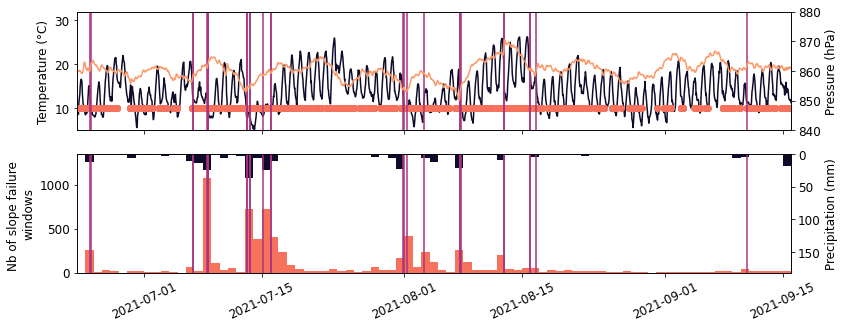

In [85]:
cmcolors = plt.get_cmap('magma').colors
# Specify colors
colors = [cmcolors[20],cmcolors[120],cmcolors[180],cmcolors[200]]
    
fig, (ax1,ax0) = plt.subplots(2,1,figsize=(6.4*2, 4.8), sharex=True)
# Plot air temperature over time
ax1.plot_date(df_ns_mask.index, df_ns_mask['261'], '-', color=colors[0], label='Air temperature')
# Plot slope failures over time
ax1.plot(dttimes, [x*10 for x in all_class], 'o', color=colors[2], label='Slope failures')

ax1.set_ylim(5,32)

ax2 = ax1.twinx()
ax3 = ax0.twinx()
# Plot precipitation over time
ax2.plot_date(df_ns_mask.index, df_ns_mask['306'], '-',color=colors[3], label='Atmospheric pressure')

ax1.set_ylabel('Temperature (°C)')
ax2.set_ylabel('Pressure (hPa)')
ax2.set_ylim(840,880)
#ax1.set_xlim(datetime.strptime('201906191945', "%Y%m%d%H%M"), datetime.strptime('201909191945', "%Y%m%d%H%M"))
ax1.set_xlim(tstart.datetime,tend.datetime)

# Plot debris-flow events as vertical lines
for ts_i in ts:
    ax1.axvline(datetime.strptime(ts_i,"%Y-%m-%dT%H:%M:%S"), color=colors[1])
    ax3.axvline(datetime.strptime(ts_i,"%Y-%m-%dT%H:%M:%S"), color=colors[1])

# Plot slope failures per day
ax0.bar(df_gr_mask.index, df_gr_mask['classes'], width=1, color=colors[2],align='edge', label='Nb of slope failures per day')
ax0.xaxis_date()
ax0.set_ylabel('Nb of slope failure \nwindows')
ax0.tick_params(axis='x', rotation=25)
ymax = np.max(df_gr_mask['classes'])+0.25*np.max(df_gr_mask['classes'])
ax0.set_ylim(0,ymax)

# Plot precipitation per daz
ax3.bar(df_ns_gr_mask.index, df_ns_gr_mask['267'], width=1 ,color=colors[0], align='edge', label='Precipitation per day')
ax3.xaxis_date()
ax3.set_ylabel('Precipitation (mm)')
ax3.set_ylim(0,np.max(df_ns_gr_mask['267'])/(ymax-np.max(df_gr_mask['classes']))*ymax) # adjust the second yscale to 100%
ax3.set_ylim(ax3.get_ylim()[::-1])

plt.savefig(f'../plot/{year}/0_eval_{year}_{plot_ending}.png',bbox_inches='tight', dpi=300)


In [86]:
# Get start and endtime
#tstart = obspy.UTCDateTime(f'{year}-06-21')
tend = tstart + timedelta(days=7)

# Mask data untl 3 hours before and 5 hours after
gr_mask = (df_group.index > tstart.date) & (df_group.index <= tend.date) # daily
ns_mask = (ns_dat.index > tstart.datetime) & (ns_dat.index<= tend.datetime) # houerly
ns_gr_mask = (ns_group.index > tstart) & (ns_group.index<= tend) #daily
df_gr_mask = df_group[gr_mask]
df_ns_mask = ns_dat[ns_mask]
df_ns_gr_mask = ns_group[ns_gr_mask]

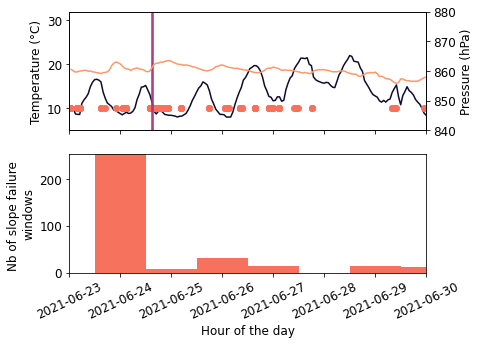

In [87]:
# Zoom in
cmcolors = plt.get_cmap('magma').colors
colors = [cmcolors[20],cmcolors[120],cmcolors[180],cmcolors[200]]
fig, (ax1,ax0) = plt.subplots(2,1,figsize=(6.4, 4.8), sharex=True)

ax1.plot_date(df_ns_mask.index, df_ns_mask['261'], '-', color=colors[0], label='Air temperature at surface')
ax1.plot(dttimes, [x*10 for x in all_class], 'o', color=colors[2], label='Slope failures')

# Plot debris-flow events as vertical lines
for ts_i in ts:
    ax1.axvline(datetime.strptime(ts_i,"%Y-%m-%dT%H:%M:%S"), color=colors[1])
ax1.set_ylim(5,32)

ax2 = ax1.twinx()
ax2.plot_date(df_ns_mask.index, df_ns_mask['306'], '-',color=colors[3], label='Atmospheric pressure')
ax1.set_ylabel('Temperature (°C)')
ax2.set_ylabel('Pressure (hPa)')

# Limit to zoom
#ax1.set_xlim(datetime.strptime('2019060000', "%Y%m%d%H%M"), datetime.strptime('201906230000', "%Y%m%d%H%M"))
ax1.set_xlim(tstart.datetime,tend.datetime)
ax1.tick_params(axis='x', rotation=25)
#ax1.legend(loc='upper right')
#ax2.legend(loc='lower right')
ax2.set_ylim(840,880)

ax0.bar(df_gr_mask.index, df_gr_mask['classes'], width=1, color=colors[2])
ax0.set_xlabel('Hour of the day')
ax0.set_ylabel('Nb of slope failure \nwindows')
ax0.set_ylim(0,np.max(df_gr_mask['classes']))
ax0.tick_params(axis='x', rotation=25)

#plt.legend(bbox_to_anchor = (1.04,1), loc="upper left")

plt.savefig(f'../plot/{year}/eval_{year}_zoom_{plot_ending}.png', bbox_inches='tight', dpi=300)

## Higher resolution

Plot data in higher resolution during debris-flow events

In [88]:
# Reassemble all window times and classes
class_res = pd.DataFrame({'datetimes': dttimes, 'classes': all_class})
print(class_res.head())

# Group hourly
df_group = class_res.resample('H', on='datetimes').sum()                                                    
print(df_group.head())

# Resample precipitation to hourly sum
ns_group = ns_dat.resample('H', on='datetime').sum()
print(ns_group.head())

            datetimes  classes
0 2021-07-02 00:00:20        0
1 2021-07-02 00:00:30        0
2 2021-07-02 00:00:40        0
3 2021-07-02 00:00:50        0
4 2021-07-02 00:01:00        0
                     classes
datetimes                   
2021-06-23 00:00:00       10
2021-06-23 01:00:00        0
2021-06-23 02:00:00        0
2021-06-23 03:00:00        7
2021-06-23 04:00:00        0
                      266  261  267  274  269  283    306    580
datetime                                                        
2021-01-01 00:00:00  56.3 -3.2  0.0    0    1  2.0  845.3     21
2021-01-01 01:00:00  59.8 -3.7  0.0    0    1  1.4  845.2  32767
2021-01-01 02:00:00  61.0 -4.1  0.0    0    1  1.6  845.2  32767
2021-01-01 03:00:00  57.5 -3.5  0.0    0    1  1.9  845.3  32767
2021-01-01 04:00:00  59.5 -3.4  0.0    0    1  1.4  845.1  32767


In [89]:
# Define which debris-flow event you want to plot
evnb = 2 #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# Get start and endtime
tds = obspy.UTCDateTime(ts[evnb]).datetime
tde = obspy.UTCDateTime(te[evnb]).datetime

# Mask data untl 3 hours before and 5 hours after
dec_mask = (df_group.index > tds - timedelta(seconds=3*3600)) & (df_group.index <= tde + timedelta(seconds=5*3600))
ns_mask = (ns_group.index > tds - timedelta(seconds=3*3600)) & (ns_group.index<= tde + timedelta(seconds=5*3600))
decs = df_group[dec_mask]
nss = ns_group[ns_mask]

tstart = obspy.UTCDateTime(ts[evnb])
tend = obspy.UTCDateTime(te[evnb]) + 5*3600

# Get raw data
st = obspy.read(path_to_raw_data + f"{year}/XP/ILL?8/EHZ.D/*.ILL?8.*{tstart.julday}")
#st1 = st.select(station=["ILL16", "ILL17", "ILL18"])

# Append raw data if endtime is on the next day 
if tend > st[0].stats.endtime:
    st1 = obspy.read(path_to_raw_data + f"{year}/XP/ILL?8/EHZ.D/*.ILL?8.*{tstart.julday + 1}")
    for tr in st1:
        st += tr
    
# Som preprocessing
st.merge(fill_value='interpolate')
st.trim(tstart-3*3600, tend+5*3600)
st.merge(method='interpolate')
st.taper(0.01)
tr = st[0]

# Compute spectrogram
f, t, Sxx = signal.spectrogram(tr.data, tr.stats.sampling_rate, nperseg=1024, noverlap=512, nfft=2048)
tr1 = tr.copy().filter('bandpass', freqmin=5, freqmax=10)
tr1

XP.ILL18..EHZ | 2021-06-22T17:12:46.000000Z - 2021-06-23T07:29:26.000000Z | 100.0 Hz, 5140001 samples

<ipython-input-90-eedf071ee907>:14: RuntimeWarning: divide by zero encountered in log10
  im = ax2.pcolormesh([tr.stats.starttime.datetime + timedelta(seconds=x) for x in t], f, 10*np.log10(Sxx), cmap=cmap, vmin=2,vmax=25,rasterized=True)


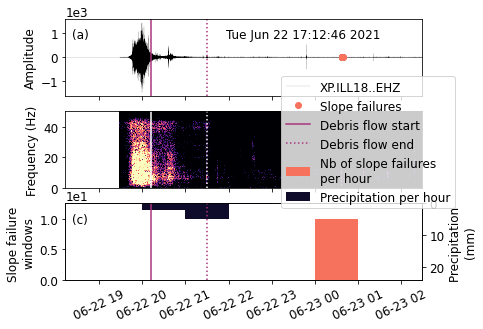

In [90]:
#colors = sns.color_palette('magma', 3)
cmcolors = plt.get_cmap('magma').colors
cmap = plt.get_cmap('magma')
    #colors = cycle([cmcolors[20],cmcolors[100],cmcolors[150],cmcolors[200]])
colors = [cmcolors[20],cmcolors[120],cmcolors[180],cmcolors[200]]
    
fig, (ax1,ax2,ax0) = plt.subplots(3,1,figsize=(6.4, 4.8), sharex=True)
#ax1.plot_date(ns_dat.index, ns_dat['261'], '-', color=colors[0], label='Air temperature')

# Plot raw data
ax1.plot_date(tr1.times('matplotlib'), tr1.data,'k-', linewidth=0.1, label=tr.id)

# Plot spectrogram
im = ax2.pcolormesh([tr.stats.starttime.datetime + timedelta(seconds=x) for x in t], f, 10*np.log10(Sxx), cmap=cmap, vmin=2,vmax=25,rasterized=True)

# Plot slope failures
ax1.plot(tslops, dslops, 'o', color=colors[2], label='Slope failures')

ax2.set_ylabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude')

# Plot bar plot with slope failures per hour
ax0.bar(decs.index, decs['classes'], width=0.042, color=colors[2],  align='edge', label='Nb of slope failures \nper hour')
ax0.xaxis_date()
ax0.set_ylabel('Slope failure \nwindows')
ax0.tick_params(axis='x', rotation=25)
ymax = np.max(decs['classes'])+0.25*np.max(decs['classes'])
ax0.set_ylim(0,ymax)

# Plot bar plot with precipitation per hour
ax3 = ax0.twinx()
ax3.bar(nss.index, nss['267'], width=0.042 ,color=colors[0], label='Precipitation per hour', align='edge')
ax3.xaxis_date()
ax3.set_ylabel('Precipitation \n(mm)')
ax3.set_ylim(0,np.max(nss['267'])/(ymax-np.max(decs['classes']))*ymax) # adjust the second yscale to 100%
ax3.set_ylim(ax3.get_ylim()[::-1]) # slip y scale

# Plot debris-flow start and end
for ax in (ax3,ax1,ax2):
    if ax == ax1:
        ax.axvline(tds, color=colors[1], label= 'Debris flow start')
        ax.axvline(tde, color=colors[1], linestyle=':',label= 'Debris flow end')
    elif ax == ax2:
        ax.axvline(tds, color='white')
        ax.axvline(tde, color='white', linestyle=':')
    else:
        ax.axvline(tds, color=colors[1])
        ax.axvline(tde, color=colors[1], linestyle=':')

ax0.set_xlim(tds - timedelta(seconds=2*3600), tde + timedelta(seconds=5*3600))

#ax3.legend(loc="upper right")
#ax0.legend(loc='lower right')
fig.legend(bbox_to_anchor = [1, 0.75])
#ax2.legend(loc='lower right')
annot = ['(a)','(b)', '(c)']
axes = (ax1, ax2, ax0)
for ax, an in zip(axes,annot):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    if an == '(b)':
        ax.text(xlim[0] + 0.02*(xlim[1] - xlim[0]), ylim[1] - 0.25*(ylim[1] - ylim[0]), an, color='white')
    elif an == '(a)':
        ax.text(xlim[0] + 0.02*(xlim[1] - xlim[0]), ylim[1] - 0.25*(ylim[1] - ylim[0]), an)
        ax.text(xlim[0] + 0.45*(xlim[1] - xlim[0]), ylim[1] - 0.25*(ylim[1] - ylim[0]), tr.stats.starttime.ctime())
    else:
        ax.text(xlim[0] + 0.02*(xlim[1] - xlim[0]), ylim[1] - 0.25*(ylim[1] - ylim[0]), an)
        
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax0.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.savefig(f'../plot/{year}/0_eval_{tr.stats.starttime.date}_{plot_ending}.png',bbox_inches='tight', dpi=300)

In [91]:
# Get start and endtime
#tstart = obspy.UTCDateTime(f'{year}-06-21')
tstart = obspy.UTCDateTime(obspy.UTCDateTime(ts[evnb]).date)
tend = tstart + timedelta(days=1)

gr_mask = (df_group.index > tstart.datetime) & (df_group.index <= tend.datetime) # daily
ns_gr_mask = (ns_group.index > tstart.datetime) & (ns_group.index<= tend.datetime) #daily
df_gr_mask = df_group[gr_mask]
df_ns_gr_mask = ns_group[ns_gr_mask]

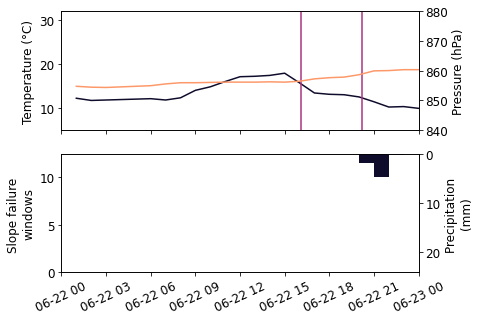

In [92]:
# Zoom in
cmcolors = plt.get_cmap('magma').colors
colors = [cmcolors[20],cmcolors[120],cmcolors[180],cmcolors[200]]
fig, (ax1,ax0) = plt.subplots(2,1,figsize=(6.4, 4.8), sharex=True)

ax1.plot_date(df_ns_gr_mask.index, df_ns_gr_mask['261'], '-', color=colors[0], label='Air temperature at surface')
ax1.plot(dttimes, [x*10 for x in all_class], 'o', color=colors[2], label='Slope failures')

# Plot debris-flow events as vertical lines
for ts_i in ts:
    ax1.axvline(datetime.strptime(ts_i,"%Y-%m-%dT%H:%M:%S"), color=colors[1])
ax1.set_ylim(5,32)

ax2 = ax1.twinx()
ax2.plot_date(df_ns_gr_mask.index, df_ns_gr_mask['306'], '-',color=colors[3], label='Atmospheric pressure')
ax1.set_ylabel('Temperature (°C)')
ax2.set_ylabel('Pressure (hPa)')

# Limit to zoom
#ax1.set_xlim(datetime.strptime('2019060000', "%Y%m%d%H%M"), datetime.strptime('201906230000', "%Y%m%d%H%M"))
ax1.set_xlim(tstart.datetime,tend.datetime)
ax1.tick_params(axis='x', rotation=25)
#ax1.legend(loc='upper right')
#ax2.legend(loc='lower right')
ax2.set_ylim(840,880)

#ax0.bar(df_gr_mask.index, df_gr_mask['classes'], width=0.042, color=colors[2])
#ax0.set_xlabel('Hour of the day')
#ax0.set_ylabel('Nb of slope failure \nwindows')
#ax0.set_ylim(0,np.max(df_gr_mask['classes']))
#ax0.tick_params(axis='x', rotation=25)

# Plot bar plot with slope failures per hour
ax0.bar(df_gr_mask.index, df_gr_mask['classes'], width=0.042, color=colors[2],  align='edge', label='Nb of slope failures \nper hour')
ax0.xaxis_date()
ax0.set_ylabel('Slope failure \nwindows')
ax0.tick_params(axis='x', rotation=25)
ymax = np.max(df_gr_mask['classes'])+0.25*np.max(decs['classes'])
ax0.set_ylim(0,ymax)

# Plot bar plot with precipitation per hour
ax3 = ax0.twinx()
ax3.bar(df_ns_gr_mask.index, df_ns_gr_mask['267'], width=0.042 ,color=colors[0], label='Precipitation per hour', align='edge')
ax3.xaxis_date()
ax3.set_ylabel('Precipitation \n(mm)')
ax3.set_ylim(0,np.max(df_ns_gr_mask['267'])/(ymax-np.max(df_gr_mask['classes']))*ymax) # adjust the second yscale to 100%
ax3.set_ylim(ax3.get_ylim()[::-1]) # slip y scale

#plt.legend(bbox_to_anchor = (1.04,1), loc="upper left")

plt.savefig(f'../plot/{year}/{year}_zoom_h_{plot_ending}.png',bbox_inches='tight', dpi=300)

## Exclude number of events before/during debris flows

In [93]:
# Mask events that happend during debris flows 
class_res = pd.DataFrame({'datetimes': dttimes, 'classes': all_class})
class_mask = class_res.copy()
# dieser Schritt ist möglicherweise nicht nötig -> ich habe noch nichts gelöscht weil den kernel nicht neu gestartet habe
#if year == 2017:
#    ns_mask = xx
#if year == 2018:
#    ns_mask = (ns_dat['datetime'] > datetime.strptime('201807220000', "%Y%m%d%H%M")) & (ns_dat['datetime'] <= datetime.strptime('201810132359', "%Y%m%d%H%M"))
#if year == 2019:
#    ns_mask = (ns_dat['datetime'] > datetime.strptime('201905220000', "%Y%m%d%H%M")) & (ns_dat['datetime'] <= datetime.strptime('201910132359', "%Y%m%d%H%M"))
#if year == 2020:
#    ns_mask = (ns_dat['datetime'] > datetime.strptime('202005280000', "%Y%m%d%H%M")) & (ns_dat['datetime'] <= datetime.strptime('202009302359', "%Y%m%d%H%M"))
#if year == 2021:
#    ns_mask = (ns_dat['datetime'] > datetime.strptime('202105200000', "%Y%m%d%H%M")) & (ns_dat['datetime'] <= datetime.strptime('202107212359', "%Y%m%d%H%M"))
ns_mask = (ns_dat['datetime'] > class_res['datetimes'][0]) & (ns_dat['datetime'] <= class_res['datetimes'][len(class_res)-1])
ns_dat_per = ns_dat[ns_mask].copy()
ns_dat_mask = ns_dat_per.copy()

for i in range(len(ts)):
    tds = obspy.UTCDateTime(ts[i]).datetime
    tde = obspy.UTCDateTime(te[i]).datetime
    dec_mask = (class_res['datetimes'] > tds - timedelta(seconds=3*3600)) & (class_res['datetimes'] <= tde+ timedelta(seconds=1*3600))
    class_mask.loc[class_mask[dec_mask].index, 'classes'] = 0
    ns_mask = (ns_dat['datetime'] > tds - timedelta(seconds=3*3600)) & (ns_dat['datetime'] <= tde+ timedelta(seconds=1*3600))
    ns_dat_mask.loc[ns_dat_per[ns_mask].index, '267'] = 0

<ipython-input-93-425ed829e348>:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ns_dat_mask.loc[ns_dat_per[ns_mask].index, '267'] = 0


In [94]:
df_group = class_res.groupby([class_res['datetimes'].dt.hour]).sum()
#print(df_group.head())

df_group_mask = class_mask.groupby([class_mask['datetimes'].dt.hour]).sum()
df_group_mask.classes = df_group_mask.classes
#print(df_group_mask)

ns_group = ns_dat.groupby([ns_dat_per['datetime'].dt.hour]).sum()
#print(ns_group.head())

ns_group_mask = ns_dat_mask.groupby([ns_dat_mask['datetime'].dt.hour]).sum()
#print(ns_group_mask)

In [95]:
# Group hourly
group_cm = class_res.copy().resample('H', on='datetimes').sum()[1:]
group_cm.index.rename('Date', inplace=True)
group_cm.head(-10)

,classes
Date,
2021-06-23 01:00:00,0
2021-06-23 02:00:00,0
2021-06-23 03:00:00,7
2021-06-23 04:00:00,0
2021-06-23 05:00:00,4
...,...
2021-09-16 09:00:00,0
2021-09-16 10:00:00,0
2021-09-16 11:00:00,0


In [96]:
# Merge classes and precipitation data
group_all = group_cm.merge(ns_dat_mask, how='inner', on='Date')

# Group every 6 hours for clearer picture
group_all5 = group_all.copy().resample('6H', on='datetime').sum()
print(np.max(group_all5['classes']))
print(group_all5.shape)
group_all5.head()

785
(308, 9)


,classes,266,261,267,274,269,283,306,580
datetime,,,,,,,,,
2021-07-02 00:00:00,0,438.8,41.2,0.0,0,28,5.8,4304.7,163835
2021-07-02 06:00:00,0,411.8,78.8,0.0,345,3902,11.9,5167.9,196602
2021-07-02 12:00:00,5,274.0,112.5,0.0,298,4476,22.0,5164.4,196602
2021-07-02 18:00:00,2,377.8,84.1,0.0,0,216,8.2,5166.8,196602
2021-07-03 00:00:00,0,442.8,70.0,0.0,0,48,9.3,5166.6,163835


In [69]:
# ILL16
group_all5_ILL16 = group_all5.copy()

In [85]:
# ILL17
group_all5_ILL17 = group_all5.copy()

In [99]:
# ILL18
group_all5_ILL18 = group_all5.copy()

In [117]:
print(group_all5_ILL16.head())
print(group_all5_ILL17.head())
print(group_all5_ILL18.head())
print(group_all5_ILL16.shape)
print(group_all5_ILL17.shape)
print(group_all5_ILL18.shape)

                     classes    266   261  267  274   269   283     306  \
datetime                                                                  
2019-05-22 00:00:00        0  437.2  25.9  0.0    3    30   3.6  4290.1   
2019-05-22 06:00:00        0  472.1  50.9  0.0  227  2964   7.0  5152.3   
2019-05-22 12:00:00        6  276.8  79.4  0.0  203  3055  17.9  5150.7   
2019-05-22 18:00:00        1  351.0  57.2  0.0   30   175  13.1  5155.6   
2019-05-23 00:00:00        0  479.7  29.9  0.0    5    31   7.8  5156.7   

                        580  
datetime                     
2019-05-22 00:00:00  163835  
2019-05-22 06:00:00  196602  
2019-05-22 12:00:00  196602  
2019-05-22 18:00:00  196602  
2019-05-23 00:00:00  163835  
                     classes    266   261  267  274   269   283     306  \
datetime                                                                  
2019-05-22 00:00:00        4  437.2  25.9  0.0    3    30   3.6  4290.1   
2019-05-22 06:00:00        0  472.1  50

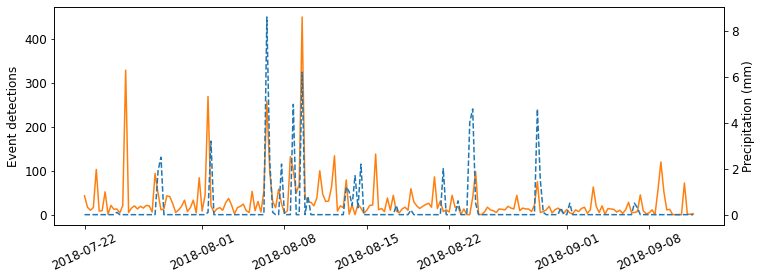

In [282]:
fig = plt.figure(figsize=(12,4))
ax = plt.subplot(111)
ax.plot_date(group_all5.index, group_all5['classes'], 'C1')
ax.set_ylabel('Event detections')
ax1 = ax.twinx()
ax1.plot_date(group_all5.index, group_all5['267'], 'C0',linestyle='--')
ax1.set_ylabel('Precipitation (mm)')
ax.tick_params(axis='x', rotation=25)

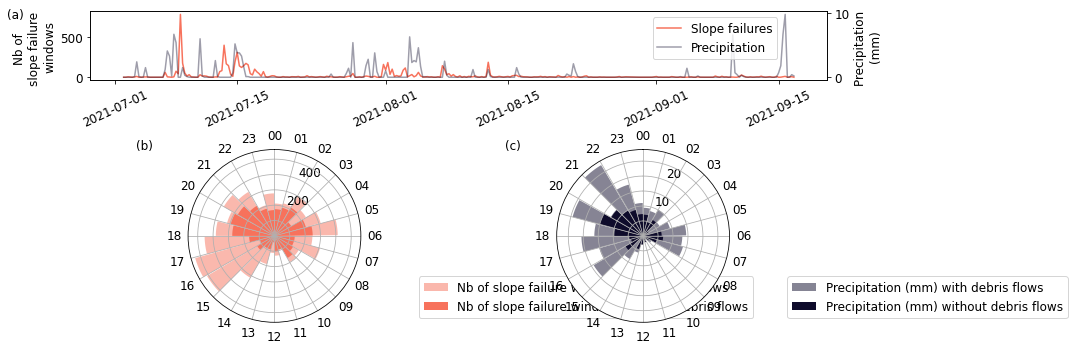

In [97]:
cmcolors = plt.get_cmap('magma').colors
    #colors = cycle([cmcolors[20],cmcolors[100],cmcolors[150],cmcolors[200]])
colors = [cmcolors[20],cmcolors[120],cmcolors[180],cmcolors[200]]
#fig, (ax1,ax0) = plt.subplots(1,2,figsize=(16,3))

fig = plt.figure(figsize = (6.4*2, 4.8))
# [left bottom width height] 
ax2 = fig.add_axes([0.1, 0.75, 0.8, 0.2]) # WAVEFORM
ax0 = fig.add_axes([0.1, 0.05, 0.4, 0.5], projection='polar') # SPECTRUM
ax1 = fig.add_axes([0.5, 0.05, 0.4, 0.5], projection='polar') # COLORBAR

#fig = plt.figure(figsize=(16,6))
#ax2 = plt.subplot(131)
#ax1 = plt.subplot(132, projection='polar')
#ax0 = plt.subplot(133, projection='polar')

ax2.plot_date(group_all5.index, group_all5['classes'], marker=None, linestyle='-', color=colors[2], label='Slope failures')
ax3 = ax2.twinx()
ax3.plot_date(group_all5.index, group_all5['267'], marker=None, linestyle='-', color=colors[0], alpha=0.4, label='Precipitation')
ax2.tick_params(axis='x', rotation=25)
ax2.set_ylabel('Nb of \nslope failure \nwindows')
ax3.set_ylabel('Precipitation \n(mm)')
fig.legend(bbox_to_anchor = [0.85, 0.98])

#ax0.projection('polar')
theta = np.linspace(0.0, 2 * np.pi, len(df_group.index), endpoint=False)
ax0.bar(theta, df_group['classes'], width=0.25, align='edge', color=colors[2], alpha=.5, label='Nb of slope failure windows with debris flows')
ax0.bar(theta, df_group_mask['classes'], width=0.25, align='edge', color=colors[2], label='Nb of slope failure windows without debris flows')
ax1.bar(theta, ns_group['267'], width=0.25, align='edge', color=colors[0], alpha=.5, label='Precipitation (mm) with debris flows')
ax1.bar(theta, ns_group_mask['267'], width=0.25, align='edge', color=colors[0], label='Precipitation (mm) without debris flows')
#ax0.set_xlabel('Hour of the day')
#ax0.set_ylabel('Nb of slope failure \nwindows')
#ax0.set_xlim(-0.5,23.5)
for ax in (ax0,ax1):
    # Make the labels go clockwise
    ax.set_theta_direction(-1)
    #Place Zero at Top
    ax.set_theta_offset(np.pi/2)
    #Set the circumference ticks
    ax.set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False))
    # set the label names
    ticks = ['00', '01', '02', '03', '04', '05', '06', '07','08','09','10','11','12', '13', '14', '15', '16',  '17', '18', '19', '20', '21', '22', '23' ]
    ax.set_xticklabels(ticks)
    # suppress the radial labels
    #plt.setp(ax0.get_yticklabels(), visible=False)
    for label in ax.yaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    ax.legend(bbox_to_anchor = [1.3, 0.3])
    plt.setp(ax.get_yticklabels()[-1], visible=False)
#plt.setp(ax0.get_yticklabels()[-2], visible=False)
fig.text(0.01,0.93, '(a)')    
fig.text(0.15,0.55, '(b)')
fig.text(0.55,0.55, '(c)')

plt.savefig(f'../plot/{year}/ns_vs_sf_{plot_ending}.png',bbox_inches='tight', dpi=300)

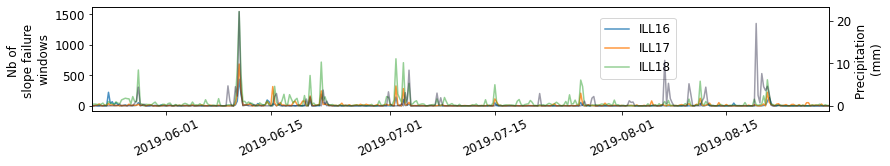

In [153]:
# ONLY TOP PLOT
cmcolors = plt.get_cmap('magma').colors
    #colors = cycle([cmcolors[20],cmcolors[100],cmcolors[150],cmcolors[200]])
colors = [cmcolors[20],cmcolors[120],cmcolors[180],cmcolors[200]]
#fig, (ax1,ax0) = plt.subplots(1,2,figsize=(16,3))

fig = plt.figure(figsize = (6.4*2, 4.8))
# [left bottom width height] 
ax2 = fig.add_axes([0.1, 0.75, 0.8, 0.3]) # WAVEFORM
#ax1 = fig.add_axes([0.5, 0.05, 0.4, 0.5], projection='polar') # COLORBAR

ax2.plot_date(group_all5_ILL16.index, group_all5_ILL16['classes'], marker=None, linestyle='-', alpha=0.8, color='C0', label='ILL16')
ax2.plot_date(group_all5_ILL17.index, group_all5_ILL17['classes'], marker=None, linestyle='-', alpha=0.8, color='C1', label='ILL17')
ax2.plot_date(group_all5_ILL18.index, group_all5_ILL18['classes'], marker=None, linestyle='-', alpha=0.5, color='C2', label='ILL18')

ax3 = ax2.twinx()
ax3.plot_date(group_all5_ILL16.index, group_all5_ILL16['267'], marker=None, linestyle='-', color=colors[0], alpha=0.4, label='Precipitation')
ax2.tick_params(axis='x', rotation=25)
ax2.set_ylabel('Nb of \nslope failure \nwindows')
ax3.set_ylabel('Precipitation \n(mm)')
ax2.legend(bbox_to_anchor = [0.8, 0.95])
ax2.set_xlim(group_all5_ILL18.index[0],group_all5_ILL18.index[-1])

plt.savefig(f'../plot/ns_vs_sf_v4_ILL_b.png',bbox_inches='tight', dpi=300)

# Different events

In [264]:
def plotwaveyspec(idx,tr,fmin, fmax, mag, dist, typ,index):
    # Setup figure
    fig = plt.figure(figsize = (12, 6))
    # [left bottom width height]
    ax1 = fig.add_axes([0.25, 0.1, 0.65, 0.2]) # WAVEFORM
    ax4 = fig.add_axes([0.1, 0.3, 0.15, 0.6]) # SPECTRUM
    ax2 = fig.add_axes([0.25, 0.3, 0.65, 0.6], sharex=ax1, sharey=ax4) # SPECTROGRAM
    ax3 = fig.add_axes([0.91, 0.3, 0.02, 0.6]) # COLORBAR

    cmap = plt.get_cmap('magma')
    #cmap = sns.color_palette("rocket", as_cmap=True)
    # Plot waveforms (left subfigure)
    #xt = tr.times()
    #ax1.plot(tr.times(), tr.data, color=cmap.colors[0], label="%s" %tr.id)
    ax1.plot(tr.times(), tr.data, color='k', linewidth=0.7,label="%s" %tr.id)
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Amplitude")
    ax1.set_xlim(0, tr.times()[-1])
    ax1.legend(loc=1)

    # Plot spectrogram (bottom right figure)
    #fig = tr.spectrogram(wlen=0.00015*len(tr.data), cmap=cmap, show=False, axes=ax2)
    f, t, Sxx = signal.spectrogram(tr.data, 100, nperseg=32, noverlap=30, nfft=1024)
    #f, t, Sxx = signal.spectrogram(tr.data, 10, nperseg=256, noverlap=128, nfft=256)
    im = ax2.pcolormesh(t, f, 10*np.log10(Sxx), cmap=cmap, vmin=0,vmax=15, rasterized=True)
    ax2.set_ylim(fmin, fmax)
    ax2.set_xlim(0, tr.times()[-1])
    if mag != 0.0:
        ax2.set_title("Station {} - {} - Distanz {} km".format(tr.stats.station,tr.stats.starttime.ctime(), dist))
        ax2.text(0.97, 0.97, f'Magnitude: {mag}\n Distanz: {dist}',
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax2.transAxes, fontsize=16, color='white')
        if typ == 'local':
            ax2.text(0.03, 0.97, f'Lokales Erdbeben',
                horizontalalignment='left',
                verticalalignment='top',
                transform=ax2.transAxes, fontsize=16, color='white')
        elif typ == 'regional':
            ax2.text(0.03, 0.97, f'Regionales Erdbeben',
                horizontalalignment='left',
                verticalalignment='top',
                transform=ax2.transAxes, fontsize=16, color='white')
        elif typ == 'teleseismic':
            ax2.text(0.03, 0.97, f'Teleseismisches Erdbeben',
                horizontalalignment='left',
                verticalalignment='top',
                transform=ax2.transAxes, fontsize=16, color='white')
    else:
        ax2.set_title("Station {} - {}".format(tr.stats.station,tr.stats.starttime.ctime()))
        ax2.text(0.03, 0.97, f'{index}',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax2.transAxes, fontsize=16, color='white')


    # Plot colorbar
    #mappable = ax2.images[0]
    cbar = plt.colorbar(mappable=im, cax=ax3)
    cbar.set_label('10*log(PSD)')

    # Plot spectrum (top right figure)
    sp, fr, line, = ax4.magnitude_spectrum(tr.data, tr.stats.sampling_rate, visible=False)
    #ax4.plot(sp,fr, color=cmap.colors[0])
    ax4.plot(sp,fr, color='k', linewidth=0.7)
    ax4.set_xlabel('Magnitude')
    ax4.set_xlim(min(sp), max(sp))
    ax4.invert_xaxis()
    ax4.set_ylabel('Frequency (Hz)')

    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.setp(ax1.get_yticklabels(), visible=False)
    plt.setp(ax4.get_xticklabels(), visible=False)
    plt.setp(ax3.get_xticklabels(), visible=False)

    #if mag !=0.0:
    #    plt.savefig(f'../comparision_catalog/30_{typ}event_{idx}.png', tranparent=True)
    #else:
    #    plt.savefig(f'../comparision_catalog/30_slope_failure_{idx}.png', tranparent=True)

    plt.savefig(f'../plot/spectrogram_{index}_neu.pdf',bbox_inches='tight', dpi=300)
    plt.show()
    
    #plt.close()


In [265]:
df = pd.read_csv('../plot_classes/event_infos.csv')
df.head()

,tstart,duration,class
0,2017-06-10T02:19:10,30,NaN
1,2017-06-06T02:31:40,30,NaN
2,2017-06-05T18:03:59,5,NaN
3,2017-06-09T06:05:36,5,NaN
4,2017-06-16T05:03:18,3,NaN


<IPython.core.display.Javascript object>


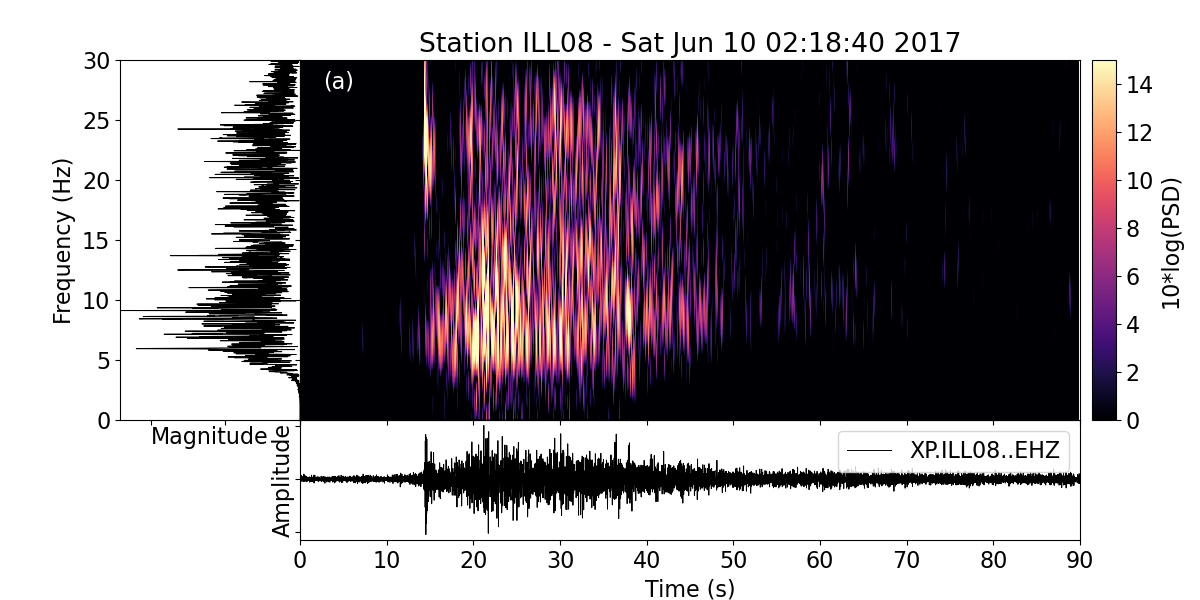

<ipython-input-264-d5f397c48df7>:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<IPython.core.display.Javascript object>


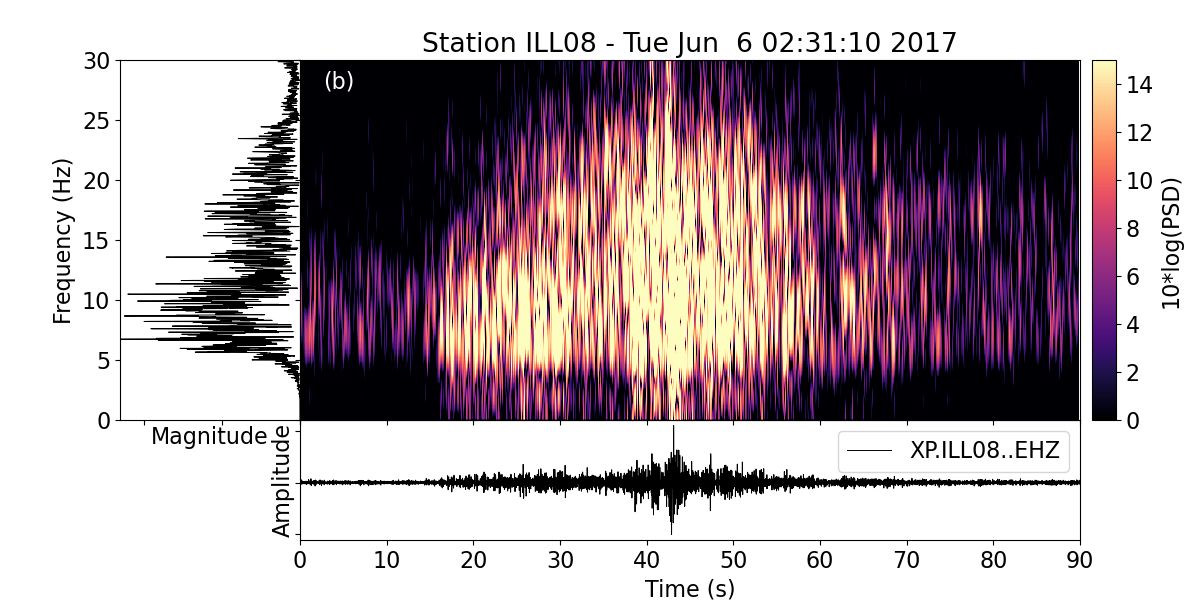

<ipython-input-264-d5f397c48df7>:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<IPython.core.display.Javascript object>


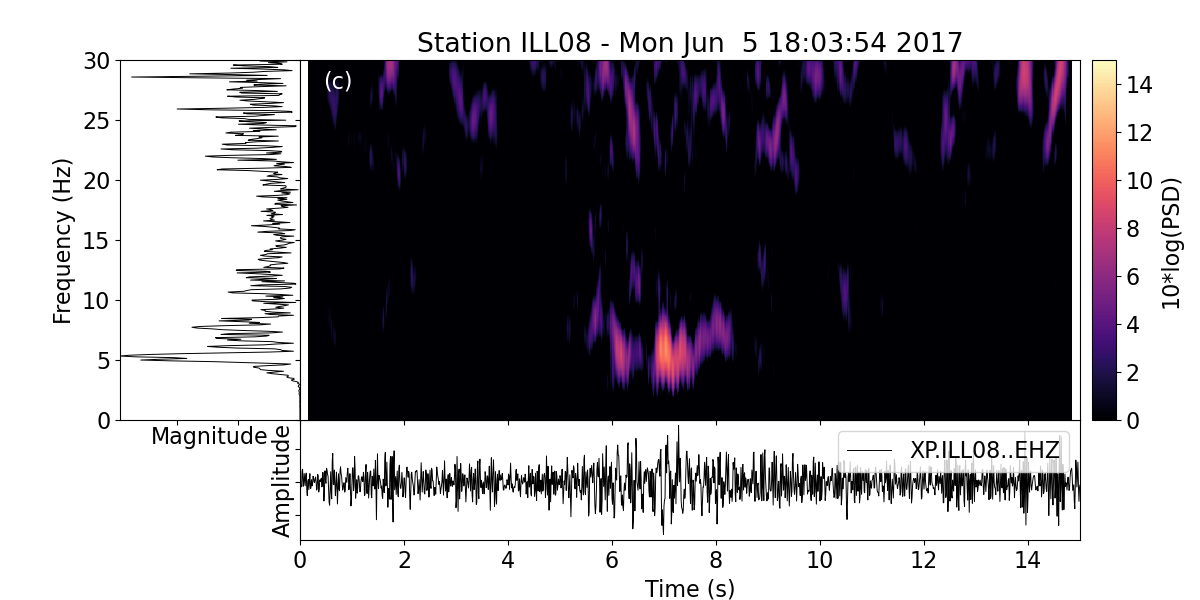

<ipython-input-264-d5f397c48df7>:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<IPython.core.display.Javascript object>


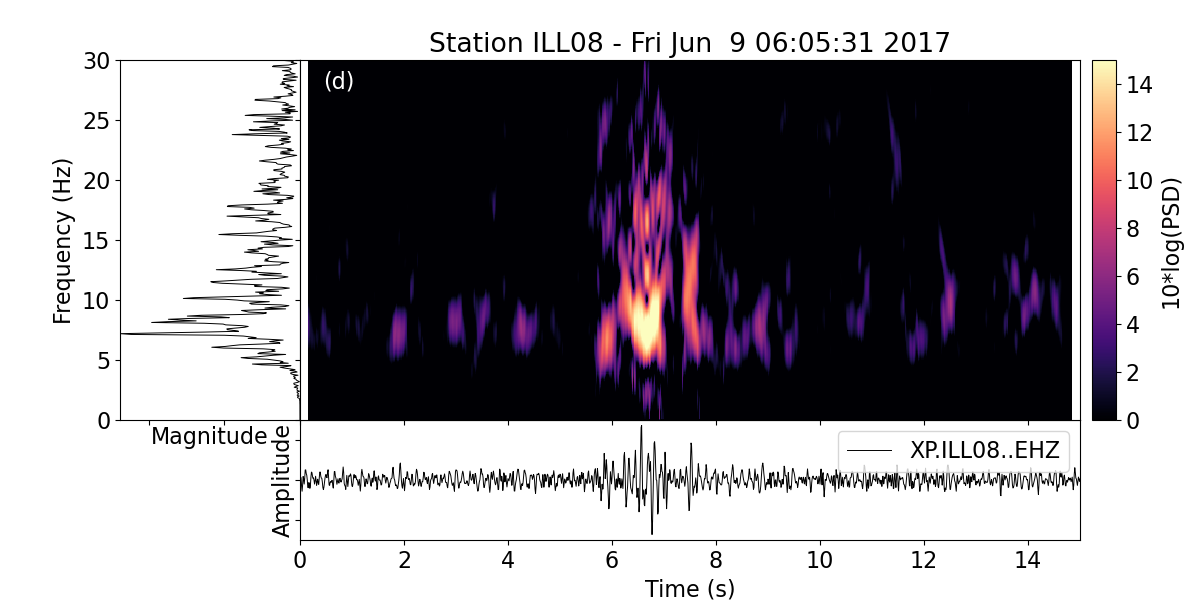

<ipython-input-264-d5f397c48df7>:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<IPython.core.display.Javascript object>


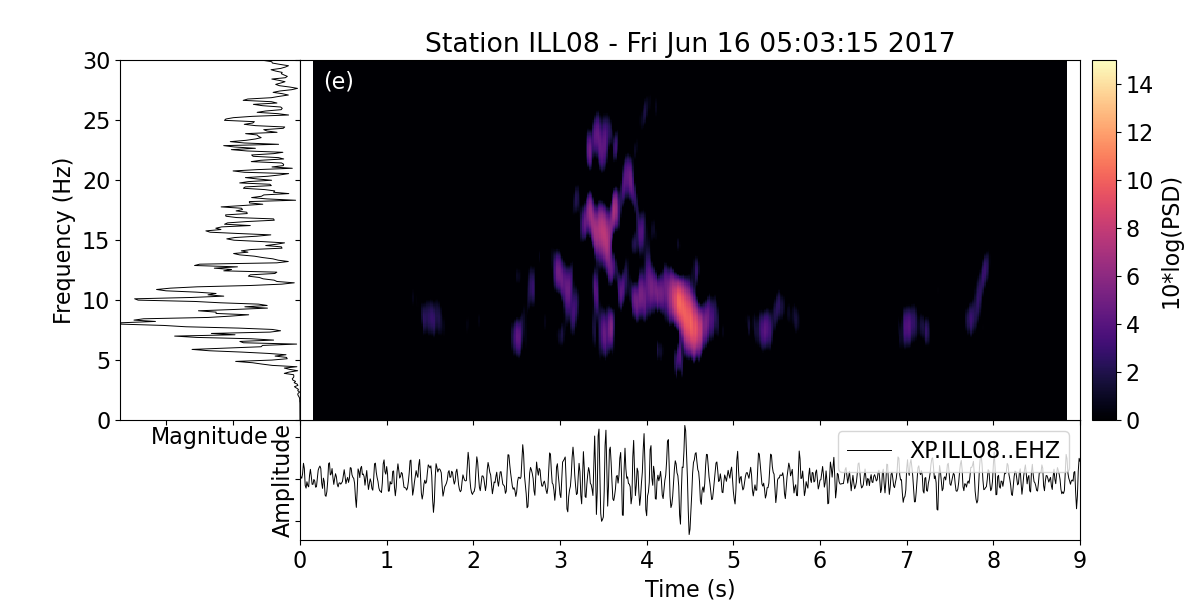

<ipython-input-264-d5f397c48df7>:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<IPython.core.display.Javascript object>


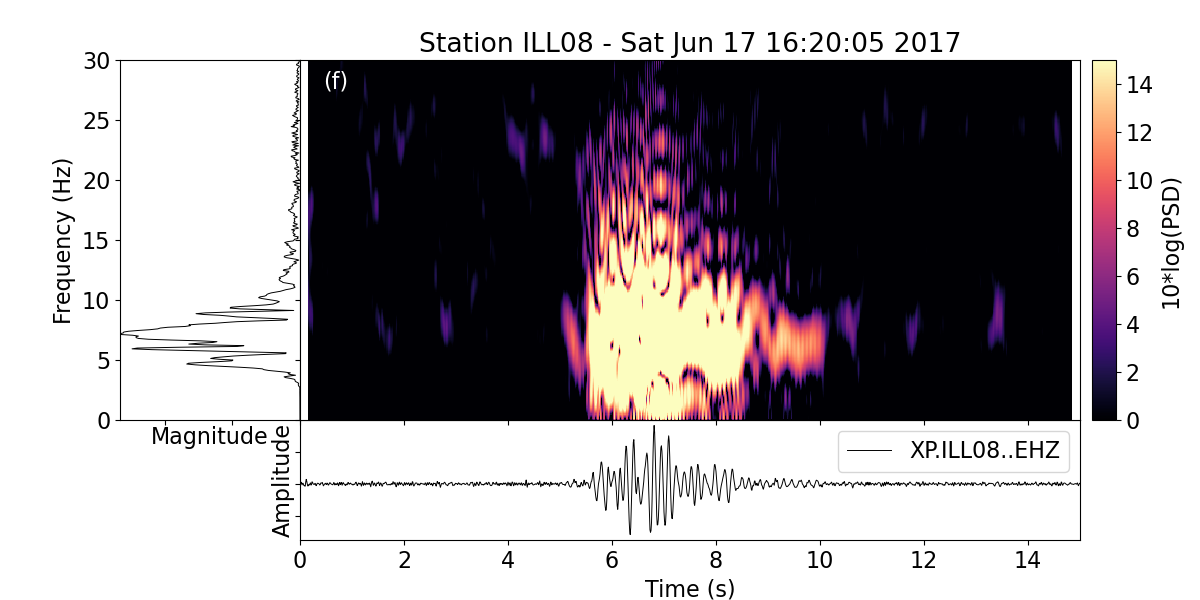

<ipython-input-264-d5f397c48df7>:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [266]:
indexe = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']
for idx, row in df.iterrows():
    t = obspy.UTCDateTime(row.tstart)
    st = obspy.read(path_to_raw_data + f'2017/XP/ILL08/EHZ.D/XP.ILL08..EHZ.D.2017.{t.julday}')
    st.detrend('demean')
    st.filter('bandpass', freqmin = 5, freqmax=30)
    st.trim(t - row.duration, t + row.duration + row.duration)
    plotwaveyspec(idx,st[0],0, 30, 0.0, 0.0, row['class'], indexe[idx])